## Spam email classification

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### loading the data

In [2]:
df = pd.read_csv('email.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### Dropping duplicates

In [4]:
df.duplicated().sum()

415

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.Category.value_counts()

Category
ham               4516
spam               641
{"mode":"full"       1
Name: count, dtype: int64

In [7]:
df = df[df['Category'] != '{"mode":"full"']

### Distribution of target variable

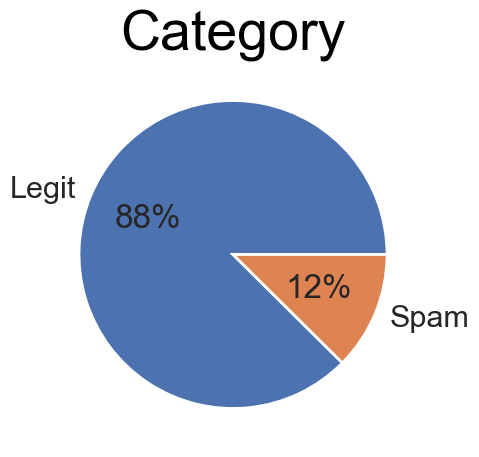

In [8]:
labels=['Legit','Spam']
values=df['Category'].value_counts().values

sns.set_theme(context='poster')
plt.figure(figsize=(5,5))
plt.title('Category', color="Black",fontsize=40)

plt.pie(values, labels=labels, autopct='%1.0f%%')
plt.show()

### Handling imbalance of the target variable

In [9]:
class_count_legit,class_count_spam = df.Category.value_counts()

class_legit = df[df['Category'] == 'ham']
class_spam = df[df['Category'] == 'spam']

print(class_legit.shape)
print(class_spam.shape)

class_legit_under = class_legit.sample(class_count_spam)

df = pd.concat([class_legit_under,class_spam])

(4516, 2)
(641, 2)


In [10]:
df.Category.value_counts()

Category
ham     641
spam    641
Name: count, dtype: int64

### Text preprocessing

In [11]:
import re
import gensim
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot,Tokenizer
from keras.models import Sequential
from keras.layers import LSTM,Dense,Embedding,Dropout

In [12]:
def preprocess_text(sent):
    tag_pattern = re.compile(r'<.*?>')
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    # Removing Punctuation & Special Characters
    sent = re.sub('[^a-zA-Z]',' ',sent)
    # Removal of HTML Tags
    sent = re.sub(tag_pattern, '', sent)
    # lowercasing
    sent = sent.lower()
    # removing single character
    sent = re.sub(r"\s+[a-zA-Z]\s+",' ',sent)
    # removing multiple spaces
    sent = re.sub(r'\s+',' ',sent)
    # Removal of URLs
    sent = re.sub(url_pattern,'',sent)
    return sent

In [13]:
corpus = list(df['Message'])
X = []
for line in corpus:
    X.append(preprocess_text(line))

### Tokenizing the data the pad sequencing

In [14]:
y = df['Category'].map({'spam':1,'ham':0})
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # splitting sentence into tokens
X_train = tokenizer.texts_to_sequences(X_train)# assigning tokens numerical values
X_test = tokenizer.texts_to_sequences(X_test) # assigning tokens numerical values

maxlen = 100
X_train = pad_sequences(X_train,padding='pre',maxlen = maxlen)
X_test = pad_sequences(X_test,padding='pre',maxlen = maxlen)

input_dim = len(tokenizer.word_index) + 1

### Loading word2Vec model,then creating embedding matrix

In [15]:
wv = KeyedVectors.load('C:/Users/odhia/PycharmProjects/Pythonrealproject/word2vec_model.kv')

In [16]:
embedding_matrix = np.zeros((input_dim,200))
for word,index in tokenizer.word_index.items():
    if word in wv:
        embedding_matrix[index] = wv[word]

### Model building

In [17]:
model = Sequential([
    Embedding(input_dim = input_dim,output_dim = 200,weights = [embedding_matrix],input_length = maxlen,trainable = False),
    Dropout(0.2), # this prevent overfitting
    LSTM(150),
    Dropout(0.2), # this prevent overfitting
    Dense(1,activation = 'sigmoid')
])

In [18]:
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics = ['accuracy'])

In [19]:
history = model.fit(X_train,y_train,batch_size = 128,epochs = 10, verbose = 1,validation_split = 0.2)

Epoch 1/10


7/7 [==============================] - 29s 1s/step - loss: 0.5644 - accuracy: 0.7659 - val_loss: 0.3625 - val_accuracy: 0.8878
Epoch 2/10
7/7 [==============================] - 3s 374ms/step - loss: 0.2602 - accuracy: 0.9220 - val_loss: 0.2055 - val_accuracy: 0.9415
Epoch 3/10
7/7 [==============================] - 2s 352ms/step - loss: 0.1866 - accuracy: 0.9329 - val_loss: 0.1516 - val_accuracy: 0.9610
Epoch 4/10
7/7 [==============================] - 2s 352ms/step - loss: 0.1732 - accuracy: 0.9354 - val_loss: 0.1651 - val_accuracy: 0.9366
Epoch 5/10
7/7 [==============================] - 2s 344ms/step - loss: 0.1290 - accuracy: 0.9549 - val_loss: 0.1722 - val_accuracy: 0.9415
Epoch 6/10
7/7 [==============================] - 2s 336ms/step - loss: 0.1370 - accuracy: 0.9500 - val_loss: 0.1466 - val_accuracy: 0.9707
Epoch 7/10
7/7 [==============================] - 2s 345ms/step - loss: 0.1152 - accuracy: 0.9707 - val_loss: 0.1445 - val_accuracy: 0.9463
Epoch 8/10
7/7 [====

In [20]:
model.evaluate(X_test,y_test)

9/9 [==============================] - 2s 184ms/step - loss: 0.1648 - accuracy: 0.9494


[0.16484761238098145, 0.9494163393974304]

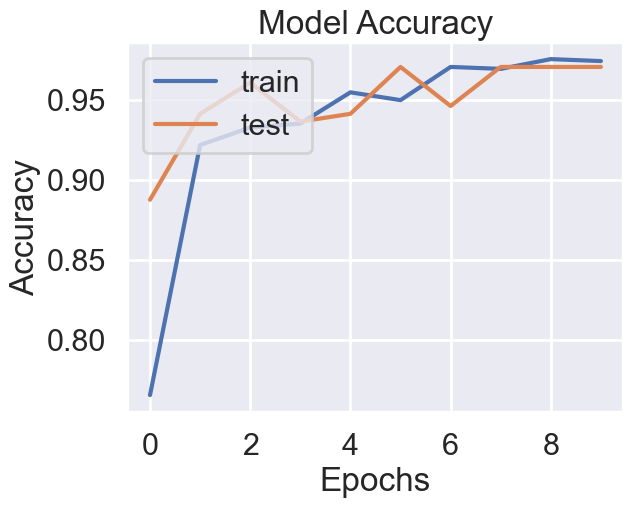

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

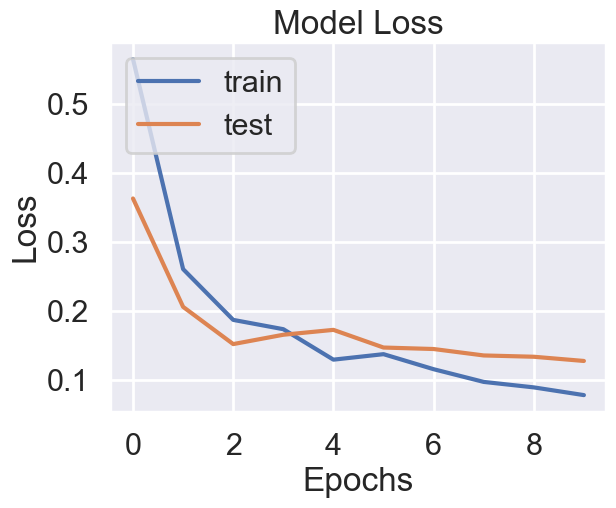

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(['train','test'],loc = 'upper left')
plt.show()

In [23]:
model.save('email.keras')

In [24]:
import pickle
pickle.dump(tokenizer,open('emailtokenizer.pkl','wb'))